In [48]:
%load_ext autoreload
%autoreload 2

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim

import sys
sys.path.append('../src/')
from simple_transformer import MultilayerTransformer, initialize_weights, train_model
from markov_utilities import epsilon_machine_to_graph, to_mixed_state_presentation, get_recurrent_subgraph
from visualization import visualize_graph_with_selective_offset
from processes import RRXORProcess

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Random-Random-XOR Process

In [3]:
# Testing the modified function
sample_data, sample_positions = RRXORProcess.generate(10, with_positions=True)
sample_data, sample_positions



(['0', '1', '1', '1', '0', '1', '1', '1', '0', '0'],
 ['R1', 'R2', 'XOR', 'R1', 'R2', 'XOR', 'R1', 'R2', 'XOR', 'R1'])

## Example data

In [4]:
''.join([str(x) for x in RRXORProcess.generate(1000)])

'100010101101110110111000011011000001110100000001110101110100000001100000001100001111001110100011000010111000011001100010100011001100011000001101101111011001111000000011010101111010110101111010101111011010111010110100011001110101111001110101100000000001110101111000001101111000001101101101111001110100011000011000001110100000001110101101111000010111011010110100000010101100001101101101110100000011010101111011011000001111010101101101101101101110100001100001110101111001100001110100010110101101101110111000010100000011000011011011011000010101100000010100010101110110101111001100001111010101101101100000010110110111000010100010111010111010100010101110111011001111001100000000011001111001101101111010110110110111001100010111000001101111000011001110110111000010101111011010111001100000010111001110111001110101110110110100000011011001111011001101111011011000000010111010111001100010101110100011010110110101110111000010101100010111010110111010111001100000001101110101101100010100001111001101101111011010100

In [5]:
# Define a config for the transformer and training
config = {
    # transformer config
    'd_vocab': 2,
    'd_model': 16,
    'input_size': 3,  # context length
    'd_head': 16,
    'n_head': 4,
    'd_mlp': 4*16,
    'n_layers': 4,
    # training config
    'batch_size': 32,
    'sequence_length': 5000,
    'num_epochs': 1000,
    'learning_rate': 1.5e-2,
    'weight_decay': 0.0,
    'patience': 10000,
    'factor': 0.5
}

# Generate sequence data with positions
sequence, sequence_positions = RRXORProcess.generate(config['sequence_length'], with_positions=True)
train_inputs, train_targets, test_inputs, test_targets = RRXORProcess.create_train_test_data(sequence, config['input_size'])
train_loader = RRXORProcess.create_data_loader(train_inputs, train_targets, config['batch_size'])
test_loader = RRXORProcess.create_data_loader(test_inputs, test_targets, config['batch_size'])

print(f"The number of batches in the training set is {len(train_loader)}")

# Model Definition
model = MultilayerTransformer(d_vocab=config['d_vocab'], d_model=config['d_model'], input_size=config['input_size'], 
                              d_head=config['d_head'], n_head=config['n_head'], d_mlp=config['d_mlp'], n_layers=config['n_layers'])
model.apply(initialize_weights)

# Check if CUDA is available and move the model to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
print('CUDA Available:', torch.cuda.is_available())

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config['patience'], factor=config['factor'], verbose=True)

# Training
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=config['num_epochs'], verbose=True)

The number of batches in the training set is 125
CUDA Available: True
| Epoch | Training Acc. | Loss | Overall Acc. | Last Bit Acc. |
|   1   |    52.93%    |    0.6908     |      55.66%       |      58.59%      |


KeyboardInterrupt: 

# RRXOR Epsilon Machine analysis



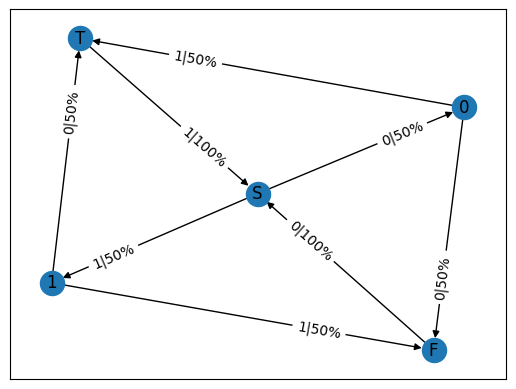

In [75]:
T, state_names = RRXORProcess.get_epsilon_machine(with_state_names=True)
G = epsilon_machine_to_graph(T, state_names)
visualize_graph_with_selective_offset(G)

MSP has shape (2, 36, 36)


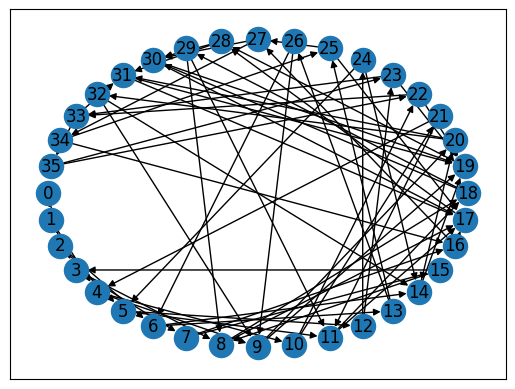

In [74]:
MSP = to_mixed_state_presentation(T, threshold=1e-5)
print("MSP has shape", MSP.shape)
G_MSP = epsilon_machine_to_graph(MSP)
visualize_graph_with_selective_offset(G_MSP, layout='shell', draw_edge_labels=False)

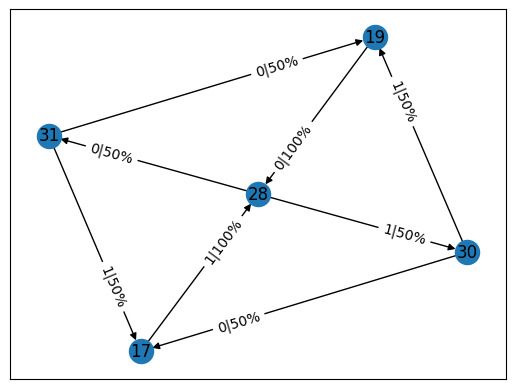

In [78]:
visualize_graph_with_selective_offset(get_recurrent_subgraph(G_MSP))